## ===== Part 1: Analyze stock trends =====

Change parameter below

In [1]:
TICKER = "MSFT"
PERIOD = "6mo"  # one of 3mo, 6mo, 1y, 2y

In [2]:
import yfinance as yf


ticker = yf.Ticker(TICKER)
symbol = ticker.info["symbol"]
name = ticker.info["displayName"]
df = ticker.history(period=PERIOD)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-03 00:00:00-05:00,419.467282,422.405996,417.933202,421.728607,16662900,0.0,0.0
2025-01-06 00:00:00-05:00,426.360784,432.656586,423.850447,426.211365,20573600,0.0,0.0
2025-01-07 00:00:00-05:00,427.356962,429.000637,419.188356,420.752350,18139100,0.0,0.0
2025-01-08 00:00:00-05:00,421.838197,425.334764,419.925568,422.933990,15054600,0.0,0.0
2025-01-10 00:00:00-05:00,423.003698,423.083378,413.430488,417.345459,20201100,0.0,0.0


In [3]:
"""Partition stock trends into major changes"""

import numpy as np

from src.stock_gone_wrong.signal import (find_largest_changes,
                                         find_stock_peaks, remove_saddle)

data = df["Close"].to_numpy()
maxima = find_stock_peaks(data, window=2)
minima = find_stock_peaks(-data, window=2)

extrema = np.unique(np.concat(([0, data.size - 1], minima, maxima)))
trends = remove_saddle(data, extrema)
changes = find_largest_changes(data, trends, 5)

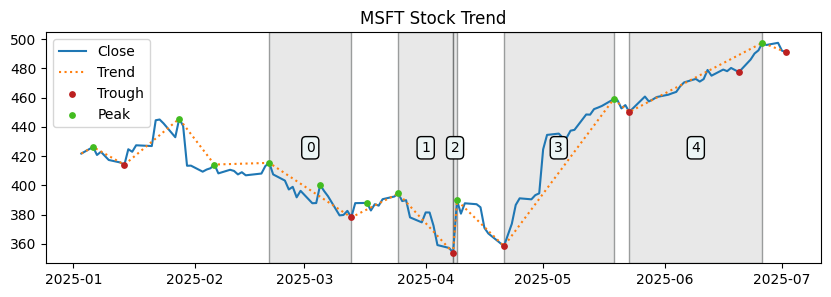

In [10]:
"""Visualize the partition results, and highlight major upturns/downturns"""

from matplotlib import pyplot as plt


plt.figure(figsize=(10, 3))
mid_y = (data.min() + data.max()) / 2
bbox = {
    "facecolor": "#ECF5F5",
    "edgecolor": "black",
    "boxstyle": "round,pad=0.3",
}
for i, (x, y) in enumerate(changes):
    plt.axvspan(
        df.index[x],
        df.index[y],
        facecolor="lightgray",
        edgecolor="#434747",
        alpha=0.5,
        zorder=-10,
    )
    mid_x = df.index[x] + (df.index[y] - df.index[x]) / 2
    plt.text(mid_x, mid_y, f"{i}", ha="center", va="center", zorder=20, bbox=bbox)
plt.plot(df["Close"], label="Close")
plt.plot(df["Close"].iloc[trends], linestyle=":", label="Trend")
plt.scatter(
    df.index[minima], data[minima], s=15, color="#BC2020", zorder=10, label="Trough"
)
plt.scatter(
    df.index[maxima], data[maxima], s=15, color="#42BC20", zorder=10, label="Peak"
)
plt.title(f"{symbol} Stock Trend")
plt.legend()
plt.show()

## ===== Part 2: Explain stock event =====

Change parameter below

In [ ]:
CHANGE = 3  # refer to the graph
MODEL = "granite3.2:8b"  # one of installed ollama models, for question answering
EMBEDDING = "llama3.2:1b"  # one of installed ollama models, for embedding

In [12]:
from langchain_ollama import ChatOllama, OllamaEmbeddings

try:
    chat = ChatOllama(model=MODEL)
    embeddings = OllamaEmbeddings(model=EMBEDDING)
    response = chat.stream("Who was the first man on the moon?")
    for r in response:
        break
    embeddings.embed_query("Stock price analysis")
    print("Using ollama models successfully")
except:
    print(
        "Error in using ollama model. Please make sure it is opened and the model is available"
    )

Using ollama models successfully


In [13]:
"""Search related news on Google"""

from typing import cast

from pandas import Timestamp
from stock_gone_wrong.search_news import search_news


change = changes[CHANGE]
start_date = cast(Timestamp, df.index[change[0]])
end_date = cast(Timestamp, df.index[change[1]])
search_results = search_news(f"{name}({symbol}) stock price", start_date, end_date)
print(f"Found {len(search_results)} news")

Found 10 news


In [14]:
from stock_gone_wrong.agent import load_links

links: list[str] = [r.url for r in search_results]
vector_store = load_links(links, embeddings)

Create vector store: 100%|██████████| 85/85 [01:18<00:00,  1.08it/s]


In [15]:
from stock_gone_wrong.agent import model_qa

verb = "rise" if data[change[0]] < data[change[1]] else "drop"
query = f"Why does the stock price of {name} ({symbol}) {verb}?"
response, similar_docs = model_qa(chat, query, vector_store)

start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")
print(
    f"Event: {symbol} {verb}s from {data[change[0]]:.2f} in {start_str} to {data[change[1]]:.2f} in {end_str}"
)
print("Query:", query)
source_urls = list(set([d.metadata["source"] for d in similar_docs]))
print("Sources:", source_urls)
print("Response:", end="")
for r in response:
    print(r.content, end="")

Event: MSFT rises from 358.46 in 2025-04-21 to 458.87 in 2025-05-19
Query: Why does the stock price of Microsoft (MSFT) rise?
Sources: ['https://www.tastylive.com/news-insights/microsoft-msft-earnings-preview-ai-growth-market-uncertainty', 'https://www.nasdaq.com/articles/microsoft-msft-beats-stock-market-upswing-what-investors-need-know-0', 'https://www.investopedia.com/why-microsoft-stock-had-one-of-its-best-post-earnings-days-in-a-decade-11726613']
Response:
Microsoft's stock price rise is attributed to its strong quarterly results that surpassed Wall Street estimates. The company's cloud-computing revenue, particularly from its AI and Azure platform, saw significant growth. Additionally, upbeat changes in analysts' estimates indicate a favorable outlook on Microsoft's business health and profitability, contributing to the stock price increase.